## 1. Import necessary packages

In [1]:
import cv2
import torch

from matplotlib import pyplot as plt
from util.utils import load_state_dict
from util.visualize import plot_bounding_boxes_on_image_cv2

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load a model and class information

We encode class information into the checkpoint, use our defined `load_state_dict` to handle it.

In [2]:
from configs.salience_detr.salience_detr_focalnet_large_lrf_800_1333 import model
weight = torch.load("checkpoints/salience_detr_focalnet_large_lrf_800_1333/train/confusion_mat/best_ap50.pth")
load_state_dict(model, weight)
model.to('cuda')
model = model.eval()

Using /data/ephemeral/home/.cache/torch_extensions/py310_cu116 as PyTorch extensions root...
Detected CUDA files, patching ldflags


/data/ephemeral/Salience-DETR/models/bricks/ms_deform_attn.py:24: UserWarning: Failed to load MultiScaleDeformableAttention C++ extension: CUDA_HOME environment variable is not set. Please set it to your CUDA install root.
  warnings.warn(f"Failed to load MultiScaleDeformableAttention C++ extension: {e}")
The model and loaded state dict do not match exactly
Unexpected keys: norm.weight, norm.bias, head.weight, head.bias



In [3]:
model

SalienceDETR(
  (eval_transform): Sequential(
    (0): EvalResize()
    (1): ConvertDtype()
    (2): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=True)
  )
  (backbone): Sequential(
    (0): FocalNet(
      (patch_embed): Module(
        (proj): Conv2d(3, 192, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
        (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): Module(
        (0): Module(
          (blocks): Module(
            (0): Module(
              (modulation): Module(
                (f): Linear(in_features=192, out_features=389, bias=True)
                (focal_layers): Module(
                  (0): Module(
                    (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
                    (1): GELU(approximate=none)
                  )
                  (1): Module(
                    (0): Conv2d(192, 19

In [3]:

import torch
import pandas as pd
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from util.utils import load_state_dict


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_file, img_dir):
        self.coco = COCO(annotation_file)
        self.img_dir = img_dir
        self.image_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(img_id)[0]
        image_path = f"{self.img_dir}/{image_info['file_name']}"
        image = cv2.imread(image_path)
        torch_image = torch.tensor(image.transpose(2, 0, 1))
        return torch_image, image_info['file_name']

# Parameters

In [4]:

# Parameters
annotation = 'data/coco/test/annotations/instances_val2017.json'
data_dir = 'data/coco/test/val2017'



In [5]:
test_dataset = CustomDataset(annotation, data_dir)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
score_threshold = 0.05
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
outputs = []
for images, file_names in test_loader:
    images = [image.to(device) for image in images]
    with torch.no_grad():
        
        preds = model(images)
    outputs.extend(zip(preds, file_names))

# Generate submission file
coco = COCO(annotation)
prediction_strings = []
file_names = []
for pred, file_name in outputs:
    prediction_string = ''
    for box, score, label in zip(pred['boxes'], pred['scores'], pred['labels']):
        if score > score_threshold:
            prediction_string += f"{label} {score:.4f} {box[0]:.4f} {box[1]:.4f} {box[2]:.4f} {box[3]:.4f} "
    prediction_strings.append(prediction_string)
    file_names.append(file_name)

submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('./salience_detr_submission_0003.csv', index=False)
print(submission.head())


> /tmp/ipykernel_725297/1124771939.py(8)<module>()
      6     with torch.no_grad():
      7         import pdb; pdb.set_trace()
----> 8         preds = model(images)
      9     outputs.extend(zip(preds, file_names))
     10 

> /tmp/ipykernel_725297/1124771939.py(6)<module>()
      4 for images, file_names in test_loader:
      5     images = [image.to(device) for image in images]
----> 6     with torch.no_grad():
      7         import pdb; pdb.set_trace()
      8         preds = model(images)

> /tmp/ipykernel_725297/1124771939.py(9)<module>()
      7         import pdb; pdb.set_trace()
      8         preds = model(images)
----> 9     outputs.extend(zip(preds, file_names))
     10 
     11 # Generate submission file

> /tmp/ipykernel_725297/1124771939.py(4)<module>()
      2 device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
      3 outputs = []
----> 4 for images, file_names in test_loader:
      5     images = [image.to(device) for image in image

In [31]:
predictions = model([torch_image])[0]
# The following code also works:
# predictions = model(torch_image.unsqueeze(0))[0]

## 4. Visualize results

In [38]:
image_for_show = plot_bounding_boxes_on_image_cv2(
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    boxes=predictions["boxes"],
    labels=predictions["labels"],
    scores=predictions["scores"],
    classes=model.CLASSES,  # class information
    show_conf=0.5,
    font_scale=0.5,
    box_thick=2,
    text_alpha=0.75,
)

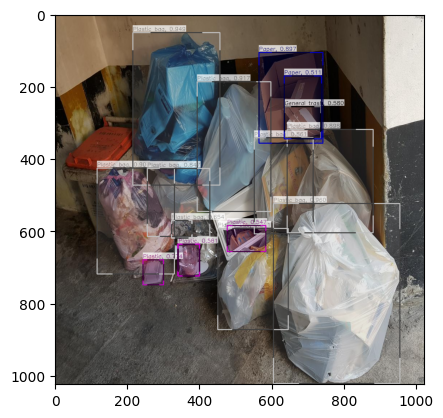

In [39]:
plt.imshow(image_for_show)